## Regex

In [1]:
import numpy as np
import pandas as pd

import re
import string
from numpy import inf

## Bag of Words

### Manual approach

In [2]:
from collections import Counter, OrderedDict
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [3]:
## Manual bag of words

df = pd.read_csv('data_for_notes/imdb_sentiment.csv')
docs = df.text[:200]


def clean(doc):
    # remove html tags
    doc = re.sub("<[^>]*>", "", doc)
    # lowercase
    doc = doc.lower()
    # tokenize
    words = tokenizer.tokenize(doc)
    # remove punctuation
    words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    stems = list(map(stemmer.stem, words))
    new_doc = " ".join(stems)
    return new_doc


def build_vocabulary(docs):
    vocabulary = Counter()
    stop_words = set(stopwords.words("english"))
    for doc in docs:
        words = [word for word in doc.split() if word not in stop_words]
        vocabulary.update(words)
    
    return OrderedDict(vocabulary.most_common())

def vectorize(docs):
    vocabulary = build_vocabulary(docs)
    vectors = []
    for doc in docs:
        words = doc.split()
        stop_words = set(stopwords.words("english"))
        vector = np.array([doc.count(word) for word in vocabulary if word not in stop_words])
        vectors.append(vector)
        
    return pd.DataFrame(vectors, columns=vocabulary)    



tokenizer = WordPunctTokenizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)

clean_docs = docs.apply(clean)
#print(clean_docs)
bag_of_words = vectorize(clean_docs)
bag_of_words.head()

,movi,film,one,like,time,get,watch,make,see,even,...,garlic,trilog,godspe,clad,keith,""".""",fonda,bunni,..........,dupe
0,3,5,0,0,2,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,1,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,1,1,0,4,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Manual tf-itf

def tf_itf(_df):
    def idf(column):
        return np.log2(1 + len(column) / sum(column > 0))
    
    _tf = _df.div(_df.sum(axis=1), axis=0)
    _tf_idf = (np.log2(1 + _tf)).multiply(_tf.apply(idf))
    return _tf_idf

tf_idf = tf_itf(bag_of_words)
tf_idf.head()

,movi,film,one,like,time,get,watch,make,see,even,...,garlic,trilog,godspe,clad,keith,""".""",fonda,bunni,..........,dupe
0,0.007899,0.014278,0.000000,0.000000,0.006853,0.003340,0.003761,0.010782,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.019593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.026228,0.000000,0.008219,0.005169,0.000000,0.000000,0.000000,0.000000,0.000000,0.005876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018237,0.000000,0.004282,0.005379,0.005950,0.000000,0.000000,0.000000,0.010090,0.006115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002383,0.000000,0.002230,0.000000,0.003100,0.003019,0.003399,0.000000,0.010505,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### With pipelines

In [5]:
# Standard imports
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict
import re
import string
import warnings; warnings.simplefilter('ignore')

# NLTK imports
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# SKLearn related imports
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv('data_for_notes/imdb_sentiment.csv')

# Get the text
docs = df['text']

# Split in train and validation
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
## Bag of words with sci-kit pipeline

# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, tokenizer, stemmer, regex_list,
                 lower=True, remove_punct=True):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        X = list(map(self._clean_sentence, X))
        return X
    
    def _clean_sentence(self, sentence):
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()

        # Split sentence into list of words
        words = self.tokenizer.tokenize(sentence)
            
        # Remove punctuation
        if self.remove_punct:
            words = list(filter(lambda x: x not in string.punctuation, words))

        # Stem words
        if self.stemmer:
            words = map(self.stemmer.stem, words)

        # Join list elements into string
        sentence = " ".join(words)
        
        return sentence
    
    def fit(self, *_):
        return self
    
    

We just created a class that has a transform() method that will apply the method _clean_sentence() to every sentence of its input X. Note that you can choose the tokenizer and the stemmer as inputs of this class - you can choose which ones you prefer to use. You can also give the class a list of tuples that are regexes that you want to substitute for something in your sentences.

Let's use the same tokenizer, stemmer and html regex that we were using before.

In [7]:

# Initialize a tokenizer and a stemmer
tokenizer = WordPunctTokenizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)
regex_list = [("<[^>]*>", "")
             ]


Pipeline with custom cleanner transformer, CountVectorizer implements the bag of words with adicional n-grams that you can select in the ngram_range, followed by the TfidfTransformer to apply tf-itf and a classifier (in this case multinomial NayveBayes)

In [8]:
# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB())])
# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.826

## Reducing Dimensionality

### Feature selection and truncation

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
# According to goole we should calculate the number of samples divided by the number of words per sample

num_samples = train_df.shape[0]
print("Number of samples", num_samples)
num_words_per_sample = train_df['text'].apply(len).sum()/num_samples
print("Number of words per sample", num_words_per_sample)
ratio = num_samples/num_words_per_sample
print("Ratio", ratio)

Number of samples 4000
Number of words per sample 1347.6965
Ratio 2.96802729694705


#### Reducing by truncating max_features in Tf-itf Vectorizer

In [11]:
#You can reduce the dimension by passing a max_features to TfitfVectorizer -
#which does the job of the previous CountVectorizer and TfitfTransformer
#tthis can tipicaly improve accuracy by getting rid of noisy features/n-grams

k=5000

# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=k)),
                   ('clf', MultinomialNB())])
# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.835

#### Using statistical test and the SelectKBest

In [12]:
# An alterantive is to use statistical methods such as the chi-square test to select the best features.
#These would be words/n-grams that are frequent in one class and not the others for instance.

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

k =5000

# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
                    ('selectKBest', SelectKBest(chi2, k=k)),
                   ('clf', MultinomialNB())])

# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.841

In [13]:
# You can also use f_classif to select the best features - google recommends it!

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif

k =5000

# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
                    ('selectKBest', SelectKBest(f_classif, k=k)),
                   ('clf', MultinomialNB())])

# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.83

### PCA and SVD - didn't work well

In [14]:
# 

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

n =50
seed = 42

# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
                    ('SVD', TruncatedSVD(n_components=n, random_state=seed)),
                    ('svd_norm', Normalizer(copy=False)),
                   ('clf', KNeighborsClassifier())])

# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.757

In [15]:
n =10
seed = 42
## Atempt at making PCA work for this case - DenseTransformer converts sparse matrix from tf-itf to dense

from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self


# Build the pipeline
text_clf = Pipeline([('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(0,1), stop_words='english')),
                      ('to_dense', DenseTransformer()),
                    ('PCA', PCA(n_components=n, random_state=seed)),
                   ('clf', KNeighborsClassifier())])

# Train the classifier
text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)

predicted = text_clf.predict(map(str, validation_df['text'].values))
np.mean(predicted == validation_df['sentiment'])

0.756

### More advanced pipelines

In [16]:
X = train_df['text'].apply(str).values
print(type(X))
y = train_df['sentiment'].map({'Negative' : 0, 'Positive' : 1}).values
print(y[33])

<class 'numpy.ndarray'>
1


In [17]:
#!pip install xgboost

#### Pipeline that runs several models in gridsearch cv to select best one

In [18]:
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, stemmer, regex_list,
                 lower=True, remove_punct=True):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        X = list(map(self._clean_sentence, X))
        return X
    
    def _clean_sentence(self, sentence):
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()

        # Split sentence into list of words
        words = self.tokenizer.tokenize(sentence)
            
        # Remove punctuation
        if self.remove_punct:
            words = list(filter(lambda x: x not in string.punctuation, words))

        # Stem words
        if self.stemmer:
            words = map(self.stemmer.stem, words)

        # Join list elements into string
        sentence = " ".join(words)
        
        return sentence
    
    def fit(self, *_):
        return self
    
    #def __deepcopy__(self, memo):
     #   return TextCleanerTransformer(self.tokenizer, self.stemmer, self.regex_list, self.lower, self.remove_punct)
    
    #def __deepcopy__(self, memo):
    #    return TextCleanerTransformer(copy.deepcopy(dict(self)))




In [19]:
#trying to combine a pipeline with a grid search to select model and model parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC


import copy



search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2']},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 15],
                 'classifier__max_features': [ 2, 3]}]

search_space2 = [{'classifier': [MultinomialNB()]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [1000, 5000],
                 'classifier__max_features': [ 2, 3]}]

loads_of_classifiers = [{'classifier': [MultinomialNB()]},
                        {'classifier': [RandomForestClassifier()],
                         'classifier__n_estimators': [2000]},
                        {'classifier': [KNeighborsClassifier()]},
                        {'classifier': [LogisticRegression()]},
                        {'classifier': [XGBClassifier()],
                        'classifier__n_estimators': [2000]},
                       {'classifier': [LinearSVC()]},]


search_space3 = [{'n_estimators': [10, 100, 1000],
                'max_features': [1, 2, 3]}]

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif

k =5000

# Build the pipeline
pipe = Pipeline([#('stemm', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
                    ('selectKBest', SelectKBest(f_classif, k=k)),
                   ('classifier', RandomForestClassifier())])


clf = GridSearchCV(pipe, loads_of_classifiers, cv=5, verbose=0, n_jobs=6)
# Train the classifier

X = train_df['text'].apply(str).values
y =  train_df['sentiment'].map({'Negative' : 0, 'Positive' : 1}).values
X_val = validation_df['text'].apply(str).values
y_val = validation_df['sentiment'].map({'Negative' : 0, 'Positive' : 1}).values


best_model = clf.fit(X, y)
print(best_model.best_estimator_.get_params()['classifier'])

cv_score = clf.cv_results_['mean_test_score']

print("Grid search cv scores:", cv_score)

predicted = best_model.predict(X_val)
print("Acuracy on validation:", np.mean(predicted == y_val))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Grid search cv scores: [0.845   0.83675 0.5815  0.8305  0.8145  0.5155 ]
Acuracy on validation: 0.839


In [20]:
def get_cv_summary(grid_clf):
    return pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

scores_df = get_cv_summary(clf)
scores_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier,param_classifier__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.159618,0.681536,0.84500,0.927999,"MultinomialNB(alpha=1.0, class_prior=None, fit...",NaN,"{'classifier': MultinomialNB(alpha=1.0, class_...",1,0.846442,0.924039,...,0.82875,0.933750,0.843554,0.929397,0.849812,0.929709,0.041566,0.020795,0.009189,0.003940
1,74.226024,1.831689,0.83675,1.000000,"RandomForestClassifier(bootstrap=True, class_w...",2000,{'classifier': RandomForestClassifier(bootstra...,2,0.826467,1.000000,...,0.82375,1.000000,0.843554,1.000000,0.847309,1.000000,0.868859,0.037151,0.009673,0.000000
3,5.736179,0.573079,0.83050,0.882688,"LogisticRegression(C=1.0, class_weight=None, d...",NaN,"{'classifier': LogisticRegression(C=1.0, class...",3,0.830212,0.887465,...,0.81250,0.880000,0.823529,0.879413,0.833542,0.886286,0.087899,0.029120,0.013226,0.003451
4,58.332686,0.621278,0.81450,0.999625,"XGBClassifier(base_score=0.5, booster='gbtree'...",2000,"{'classifier': XGBClassifier(base_score=0.5, b...",4,0.818976,1.000000,...,0.80750,0.999375,0.809762,0.999688,0.816020,0.999688,2.348628,0.034328,0.005032,0.000234
2,5.250758,0.709110,0.58150,0.662296,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN,{'classifier': KNeighborsClassifier(algorithm=...,5,0.569288,0.549234,...,0.56875,0.661875,0.579474,0.639488,0.591990,0.815683,0.318576,0.070633,0.011820,0.086166
5,10.847028,1.805750,0.51550,0.515500,"SVC(C=1.0, cache_size=200, class_weight=None, ...",NaN,"{'classifier': SVC(C=1.0, cache_size=200, clas...",6,0.515605,0.515474,...,0.51500,0.515625,0.515645,0.515464,0.515645,0.515464,0.932571,0.306263,0.000251,0.000063


## Spacy

In [21]:
import spacy
import pandas as pd
import itertools as it



In [22]:
#downloading default model - its the sm model!
#!python -m spacy download en
#medium model:
#!python -m spacy download en_core_web_md
#large model
#!python -m spacy download en_core_web_lg

In [23]:
nlp = spacy.load('en_core_web_lg')

In [24]:
df = pd.read_csv('data_for_notes/spam.csv', encoding='latin1')
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
df.rename(columns={"v1":"label", "v2":"message"},inplace=True)

### Creating adicional features with spacy POS and NER 

#### Function to create adiitonal features - adapt as needed

In [25]:
def create_aditional_POS_features(_df, text_column_name,_nlp, return_only_new_feats = False):
    n_adj, n_verbs, len_message= [], [], []
    _df_copy = _df.copy()
   
    for doc in _nlp.pipe(_df_copy[text_column_name]):
        n_adj.append(len([token for token in doc if token.pos_ == 'ADJ']))
        n_verbs.append(len([token for token in doc if token.pos_ == 'VERB']))
        len_message.append(len(doc))
    _df_copy['n_adj'] = pd.Series(n_adj)
    _df_copy['n_verbs'] = pd.Series(n_verbs)
    _df_copy['len_text'] = pd.Series(len_message)
    
    if return_only_new_feats:
        return _df_copy.drop(text_column_name, axis=1)
    else:
        return _df_copy



In [26]:
df_add = create_aditional_POS_features(df, "message",nlp)
df_add.head()

,label,message,n_adj,n_verbs,len_text
0,ham,"Go until jurong point, crazy.. Available only ...",4,2,24
1,ham,Ok lar... Joking wif u oni...,1,1,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,2,4,31
3,ham,U dun say so early hor... U c already then say...,1,2,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,4,15


In [27]:
train_data, test_data = train_test_split(df_add, test_size=0.2, random_state=42)

#### Text and number column selectors

In [28]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

#### Pipeline with feature union to combine features and simple model

In [29]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler


text = Pipeline([
                ('selector', TextSelector(key='message')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english'))
            ])

adj =  Pipeline([
                ('selector', NumberSelector(key='n_adj')),
                ('standard', StandardScaler())
            ])

verbs =  Pipeline([
                ('selector', NumberSelector(key='n_verbs')),
                ('standard', StandardScaler())
            ])

len_text =  Pipeline([
                ('selector', NumberSelector(key='len_text')),
                ('standard', StandardScaler())
            ])

feats = FeatureUnion([('text', text), 
                      ('adj', adj),
                      ('verbs', verbs),
                      ('len_text', len_text)
                       ])


final_pipe = Pipeline([('features',feats),
                     ('classifier', RandomForestClassifier())])

#You can pass the label to the classifier because of the feature selectors

X = train_data.drop('label', axis=1)
y =  train_data.label
X_val = test_data
y_val = test_data.label

final_pipe.fit(X, y)

preds = final_pipe.predict(X_val)
accuracy = np.mean(preds == y_val)

print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9632


#### Pipeline with feature union but also gridsearchCv to select best model from large list

In [55]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier


text = Pipeline([
                ('selector', TextSelector(key='message')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english'))
            ])

adj =  Pipeline([
                ('selector', NumberSelector(key='n_adj')),
                ('standard', StandardScaler())
            ])

verbs =  Pipeline([
                ('selector', NumberSelector(key='n_verbs')),
                ('standard', StandardScaler())
            ])

len_text =  Pipeline([
                ('selector', NumberSelector(key='len_text')),
                ('standard', StandardScaler())
            ])

feats = FeatureUnion([('text', text), 
                      ('adj', adj),
                      ('verbs', verbs),
                      ('len_text', len_text)
                       ])


final_pipe = Pipeline([('features',feats),
                       ('selectKBest', SelectKBest(f_classif, k=20000)),
                     ('classifier', RandomForestClassifier())])


loads_of_classifiers = [ {'classifier': [RandomForestClassifier()],
                         'classifier__n_estimators': [2000]},
                        {'classifier': [KNeighborsClassifier()]},
                        {'classifier': [LogisticRegression()]},
                        {'classifier': [XGBClassifier()],
                        'classifier__n_estimators': [1000]},
                       {'classifier': [LinearSVC()]},
                         {'classifier': [SVC(kernel='linear', probability=True)]},
                       {'classifier': [ExtraTreesClassifier()]},]

one_classifier = [{'classifier': [RandomForestClassifier()]},
                        ]

#You can pass the label to the classifier because of the feature selectors

X = train_data.drop('label', axis=1)
y =  train_data.label.map({'ham' : 0, 'spam' : 1})
X_val = test_data
y_val = test_data.label.map({'ham' : 0, 'spam' : 1})


clf = GridSearchCV(final_pipe, loads_of_classifiers, cv=5, verbose=1, n_jobs=6)

best_model = clf.fit(X, y)
print(best_model.best_estimator_.get_params()['classifier'])

cv_score = clf.cv_results_['mean_test_score']

print("Grid search cv scores:", cv_score)

predicted = best_model.predict(X_val)
print("Acuracy on validation:", np.mean(predicted == y_val))


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:  1.0min finished


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid search cv scores: [0.96903747 0.89118241 0.95759479 0.9715055  0.9860893  0.9867624
 0.97307606]
Acuracy on validation: 0.9811659192825112


In [56]:
scores_df = get_cv_summary(clf)
scores_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier,param_classifier__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,6.630916,0.200715,0.986762,0.998542,"SVC(C=1.0, cache_size=200, class_weight=None, ...",NaN,"{'classifier': SVC(C=1.0, cache_size=200, clas...",1,0.984305,0.998878,...,0.987654,0.998598,0.991021,0.998317,0.978676,0.998598,0.307553,0.020943,0.004887,0.000210
4,0.868570,0.067414,0.986089,0.999832,"LinearSVC(C=1.0, class_weight=None, dual=True,...",NaN,"{'classifier': LinearSVC(C=1.0, class_weight=N...",2,0.984305,1.000000,...,0.985410,1.000000,0.991021,1.000000,0.978676,0.999439,0.054041,0.008714,0.004633,0.000224
6,0.593773,0.070691,0.973076,1.000000,"ExtraTreesClassifier(bootstrap=False, class_we...",NaN,{'classifier': ExtraTreesClassifier(bootstrap=...,3,0.978700,1.000000,...,0.975309,1.000000,0.966330,1.000000,0.975309,1.000000,0.035734,0.007085,0.004434,0.000000
3,16.581615,0.117387,0.971505,0.994223,"XGBClassifier(base_score=0.5, booster='gbtree'...",1000,"{'classifier': XGBClassifier(base_score=0.5, b...",4,0.974215,0.995231,...,0.973064,0.992709,0.962963,0.994952,0.967452,0.994672,0.413712,0.019491,0.005802,0.000948
0,38.496927,1.489448,0.969037,1.000000,"RandomForestClassifier(bootstrap=True, class_w...",2000,{'classifier': RandomForestClassifier(bootstra...,5,0.974215,1.000000,...,0.974186,1.000000,0.964085,1.000000,0.966330,1.000000,0.841346,0.055488,0.004296,0.000000
2,0.435610,0.065619,0.957595,0.957707,"LogisticRegression(C=1.0, class_weight=None, d...",NaN,"{'classifier': LogisticRegression(C=1.0, class...",6,0.958520,0.956241,...,0.961841,0.958497,0.947250,0.959338,0.952862,0.957936,0.027535,0.005595,0.007017,0.001174
1,0.345072,0.191152,0.891182,0.905822,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN,{'classifier': KNeighborsClassifier(algorithm=...,7,0.893498,0.906592,...,0.890011,0.902131,0.891134,0.908020,0.892256,0.906898,0.045761,0.017954,0.001587,0.002016


#### Pipeline for a ensemble classifier

In [62]:
from sklearn.ensemble import  ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix


text = Pipeline([
                ('selector', TextSelector(key='message')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english'))
            ])

adj =  Pipeline([
                ('selector', NumberSelector(key='n_adj')),
                ('standard', StandardScaler())
            ])

verbs =  Pipeline([
                ('selector', NumberSelector(key='n_verbs')),
                ('standard', StandardScaler())
            ])

len_text =  Pipeline([
                ('selector', NumberSelector(key='len_text')),
                ('standard', StandardScaler())
            ])

feats = FeatureUnion([('text', text), 
                      ('adj', adj),
                      ('verbs', verbs),
                      ('len_text', len_text)
                       ])


clf1 = Pipeline([('features',feats),
                 ('classifier', RandomForestClassifier(n_estimators=2000))])
clf2 = Pipeline([('features',feats),
                 ('classifier', LogisticRegression())])
clf3 = Pipeline([('features',feats),
                 ('classifier', XGBClassifier(n_estimators=2000))])
clf4 = Pipeline([('features',feats),
                 ('classifier', SVC(kernel='linear', probability=True))])
clf5 = Pipeline([('features',feats),
                 ('classifier', ExtraTreesClassifier())])
clf6 = Pipeline([('features',feats),
                 ('classifier', MultinomialNB())])




In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

base_learners = [
    ("clf1",clf1), ("clf2",clf2), ("clf3",clf3), ("clf4",clf4), ("clf5",clf5)
]

P = np.zeros((X_val.shape[0], len(base_learners)))
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    est.fit(X, y)
    p = est.predict(X_val)
    P.loc[:, est_name] = p
    print("%3s : %.4f" % (est_name, np.mean(p == y_val)))
    



clf1 : 0.9722
clf2 : 0.9471
clf3 : 0.9641
clf4 : 0.9812
clf5 : 0.9740


ValueError: Input X must be non-negative

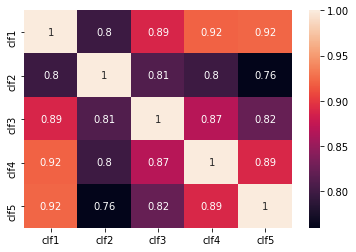

In [59]:
import seaborn as sns
sns.heatmap(P.corr(), annot=True)

In [60]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[("clf1",clf1), ("clf2",clf2), ("clf3",clf3), ("clf4",clf4), ("clf5",clf5)], 
                          voting='soft')

best_model = voting.fit(X, y)

predicted = best_model.predict(X_val)
print("Acuracy on validation:", np.mean(predicted == y_val))


Acuracy on validation: 0.97847533632287


In [61]:
best_model.predict_proba(X_val)

array([[0.9593476 , 0.04065239],
       [0.85387962, 0.14612038],
       [0.65394953, 0.34605047],
       ...,
       [0.99206882, 0.00793118],
       [0.99167532, 0.00832468],
       [0.5405378 , 0.4594622 ]])

#### MultiClass

Check this link and adapt code:

http://scikit-learn.org/stable/modules/multiclass.html

### Attempt at using vector representation of words and documents with spacy - fail in the classification

In [ ]:
def create_spacy_word_to_vec_representation(_df, text_column_name,_nlp):
    train_vec = []
    for doc in _nlp.pipe(_df[text_column_name], batch_size=500):
        if doc.has_vector:
            train_vec.append(doc.vector)
        # If doc doesn't have a vector, then fill it with zeros.
        else:
            train_vec.append(np.zeros((300,), dtype="float32"))
        

    train_vec = np.array(train_vec)
    return pd.DataFrame(train_vec)
   
    
df_vector = create_spacy_word_to_vec_representation(df, "message", nlp)

In [ ]:
df_vector.head()

In [ ]:
df_vector.shape

In [ ]:
df['message'].loc[44]

In [ ]:
# trying to make a transformer
class SpacyWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, _nlp):
        self._nlp = _nlp
        
    def transform(self, X, *_):
        train_vec = []
        for doc in self._nlp.pipe(X, batch_size=500):
            if doc.has_vector:
                train_vec.append(doc.vector)
            # If doc doesn't have a vector, then fill it with zeros.
            else:
                train_vec.append(np.zeros((300,), dtype="float32"))
        train_vec = np.array(train_vec)
        return train_vec
    
    def fit(self, *_):
        return self

spacy_vec = SpacyWord2VecVectorizer(nlp)
temp = spacy_vec.transform(df['message'])

In [ ]:
#gives an error of either memory or other things - gave up on this - cell is disabled with if statmment

if 1==0:

    from sklearn.pipeline import FeatureUnion
    from sklearn.preprocessing import StandardScaler

    train_data, test_data = train_test_split(df_add, test_size=0.2, random_state=42)

    text = Pipeline([
                    ('selector', TextSelector(key='message')),
                    ('spacy_vec', SpacyWord2VecVectorizer(nlp))
                ])

    adj =  Pipeline([
                    ('selector', NumberSelector(key='n_adj')),
                    ('standard', StandardScaler())
                ])

    verbs =  Pipeline([
                    ('selector', NumberSelector(key='n_verbs')),
                    ('standard', StandardScaler())
                ])

    len_text =  Pipeline([
                    ('selector', NumberSelector(key='len_text')),
                    ('standard', StandardScaler())
                ])

    feats = FeatureUnion([('text', text), 
                          ('adj', adj),
                          ('verbs', verbs),
                          ('len_text', len_text)
                           ])


    final_pipe = Pipeline([('features',feats),
                         ('classifier', RandomForestClassifier())])


    loads_of_classifiers = [ {'classifier': [RandomForestClassifier()],
                             'classifier__n_estimators': [1000]},
                            {'classifier': [KNeighborsClassifier()]},
                            {'classifier': [LogisticRegression()]},
                            {'classifier': [XGBClassifier()],
                            'classifier__n_estimators': [1000]},
                           {'classifier': [SVC()]},]

    one_classifier = [{'classifier': [RandomForestClassifier()]},
                            ]

    #You can pass the label to the classifier because of the feature selectors

    X = train_data.drop('label', axis=1)
    y =  train_data.label.map({'ham' : 0, 'spam' : 1})
    X_val = test_data
    y_val = test_data.label.map({'ham' : 0, 'spam' : 1})


    clf = GridSearchCV(final_pipe, one_classifier, cv=5, verbose=1, n_jobs=-1)

    best_model = clf.fit(X, y)
    print(best_model.best_estimator_.get_params()['classifier'])

    cv_score = clf.cv_results_['mean_test_score']

    print("Grid search cv scores:", cv_score)

    predicted = best_model.predict(X_val)
    print("Acuracy on validation:", np.mean(predicted == y_val))

In [ ]:
# todo create an ensemble classifier and a stacking classifier with pipelines and stuff

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

### Using spacy textclassifier - neural nets!

#### Example code from docs

https://spacy.io/usage/training#section-textcat

https://spacy.io/api/textcategorizer#call

In [ ]:
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier on the
IMDB dataset, using the TextCategorizer component. The dataset will be loaded
automatically via Thinc's built-in dataset loader. The model is added to
spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int))
def main(model=None, output_dir=None, n_iter=20, n_texts=2000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('POSITIVE')

    # load the IMDB dataset
    print("Loading IMDB data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "This movie sucked"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)


def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    train_data, _ = thinc.extra.datasets.imdb()
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


#main(model=None, output_dir='/tmp/dockerwd/spacy_models/model2', n_iter=10, n_texts=2500)

#### Code adapted to work with external dataframe - spam example

In [ ]:
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier using the TextCategorizer component. 
The model is added to spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int))
def main(_train_df, model=None, output_dir=None, n_iter=20, n_texts=0, text_column_name ='message',label_column_name='label'):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('SPAM')

    # load the IMDB dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(_train_df, text_column_name, 
                                                                 label_column_name, limit=n_texts)
    
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'A', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_a'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "BIG DICKZZ!! GIRLZZ!! VISIT www.win-454250.co.uk"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)
        
    return nlp


def load_data(_train_df, text_column_name, label_column_name, limit=0, split=0.8):
    """Load dataset."""
    # Partition off part of the train data for evaluation
    #train_data, _ = thinc.extra.datasets.imdb()
    train_data = [(row[text_column_name], row[label_column_name]) for index, row in _train_df.iterrows()]
    random.shuffle(train_data)
    #print(train_data[0:10])
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'SPAM': bool(y =='spam')} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    return {'textcat_a' : accuracy, 'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


def spacy_predict(_nlp, _test_data, label, predict_proba=True):
    predictions = []
    if predict_proba:
        for doc in _test_data.values:
            predictions.append(_nlp(doc).cats[label])
    else:
        for doc in _test_data.values:
            predictions.append(int((_nlp(doc).cats[label]) > 0.5))
    return pd.Series(predictions)


df = pd.read_csv('data_for_notes/spam.csv', encoding='latin1')
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
df.rename(columns={"v1":"label", "v2":"message"},inplace=True)


#nlp = main(df, model=None, output_dir='/tmp/dockerwd/spacy_models/model3', n_iter=5)
#nlp = main(df, model='en_core_web_lg', output_dir='/tmp/dockerwd/spacy_models/model4', n_iter=5)
#nlp = main(df, model='/tmp/dockerwd/spacy_models/model4', output_dir='/tmp/dockerwd/spacy_models/model5', n_iter=5)

In [ ]:
df = pd.read_csv('data_for_notes/spam.csv', encoding='latin1')
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
df.rename(columns={"v1":"label", "v2":"message"},inplace=True)
df.head()
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(df)
len(train_texts)

#### Adapted for other problem as example

In [ ]:
new_df = pd.read_csv('data_for_notes/imdb_sentiment.csv')
new_df.head()

In [ ]:
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier using the TextCategorizer component. 
The model is added to spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int))
def main(_train_df, model=None, output_dir=None, n_iter=20, n_texts=0, text_column_name ='message',label_column_name='label'):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('POSITIVE')

    # load the IMDB dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(_train_df, text_column_name, 
                                                                 label_column_name, limit=n_texts)
    
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'A', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_a'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "This movie sucked! Crapiest movie ever! Waste of money!"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)
        
    return nlp


def load_data(_train_df, text_column_name, label_column_name, limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #train_data, _ = thinc.extra.datasets.imdb()
    train_data = [(row[text_column_name], row[label_column_name]) for index, row in _train_df.iterrows()]
    random.shuffle(train_data)
    #print(train_data[0:10])
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y =='Positive')} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    return {'textcat_a' : accuracy, 'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

def spacy_predict(_nlp, _test_data, label, predict_proba=True):
    predictions = []
    if predict_proba:
        for doc in _test_data.values:
            predictions.append(_nlp(doc).cats[label])
    else:
        for doc in _test_data.values:
            predictions.append(int((_nlp(doc).cats[label]) > 0.5))
    return pd.Series(predictions)



#new_df = pd.read_csv('data_for_notes/imdb_sentiment.csv')

#nlp = main(new_df, model=None, output_dir='/tmp/dockerwd/spacy_models/model6', n_iter=5, 
#      text_column_name ='text',label_column_name='sentiment')



In [ ]:
#print(spacy_predict(nlp, new_df['text'], 'POSITIVE'))

#### Adapting for a multiclassification problem

TODO

In [ ]:
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier using the TextCategorizer component. 
The model is added to spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int))
def main(_train_df, model=None, output_dir=None, n_iter=20, n_texts=0, text_column_name ='message',label_column_name='label'):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('POSITIVE')

    # load the IMDB dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(_train_df, text_column_name, 
                                                                 label_column_name, limit=n_texts)
    
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'A', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_a'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "This movie sucked! Crapiest movie ever! Waste of money!"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)
        
    return nlp


def load_data(_train_df, text_column_name, label_column_name, limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #train_data, _ = thinc.extra.datasets.imdb()
    train_data = [(row[text_column_name], row[label_column_name]) for index, row in _train_df.iterrows()]
    random.shuffle(train_data)
    #print(train_data[0:10])
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y =='Positive')} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    return {'textcat_a' : accuracy, 'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

def spacy_predict(_nlp, _test_data, label, predict_proba=True):
    predictions = []
    if predict_proba:
        for doc in _test_data.values:
            predictions.append(_nlp(doc).cats[label])
    else:
        for doc in _test_data.values:
            predictions.append(int((_nlp(doc).cats[label]) > 0.5))
    return pd.Series(predictions)



#new_df = pd.read_csv('data_for_notes/imdb_sentiment.csv')

#nlp = main(new_df, model=None, output_dir='/tmp/dockerwd/spacy_models/model6', n_iter=5, 
#      text_column_name ='text',label_column_name='sentiment')

